# OCV Fitting

Open-circuit voltage fitting is the key step for conducting Degradation Mode Analysis (DMA). PyProBE has a number of built-in methods for this.

In [1]:
import pyprobe
import polars as pl
from pyprobe.analysis import degradation_mode_analysis
import numpy as np
import matplotlib.pyplot as plt

In this example, we are going to generate a synthetic aged OCV curve. We will use the half cell OCV fits from Chen 2020:

In [2]:
def graphite_LGM50_ocp_Chen2020(sto):
    """Chen2020 graphite ocp fit."""
    u_eq = (
        1.9793 * np.exp(-39.3631 * sto)
        + 0.2482
        - 0.0909 * np.tanh(29.8538 * (sto - 0.1234))
        - 0.04478 * np.tanh(14.9159 * (sto - 0.2769))
        - 0.0205 * np.tanh(30.4444 * (sto - 0.6103))
    )

    return u_eq


def nmc_LGM50_ocp_Chen2020(sto):
    """Chen2020 nmc ocp fit."""
    u_eq = (
        -0.8090 * sto
        + 4.4875
        - 0.0428 * np.tanh(18.5138 * (sto - 0.5542))
        - 17.7326 * np.tanh(15.7890 * (sto - 0.3117))
        + 17.5842 * np.tanh(15.9308 * (sto - 0.3120))
    )

    return u_eq

z = np.linspace(0, 1, 1000) # stoichiometry vector

# generate complete ocp curves
ocp_pe = nmc_LGM50_ocp_Chen2020(z)
ocp_ne = graphite_LGM50_ocp_Chen2020(z)

We will now define a set of stoichiometry limits to generate our synthetic OCV curve:

In [3]:
n_pts = 1000
# positive electrode
x_pe_lo = 0.85 # stoichiometry at low cell SOC
x_pe_hi = 0.27 # stoichiometry at high cell SOC
x_pe = np.linspace(x_pe_lo, x_pe_hi, n_pts) # stoichiometry range

# negative electrode
x_ne_lo = 0.03 # stoichiometry at low cell SOC
x_ne_hi = 0.9 # stoichiometry at high cell SOC
x_ne = np.linspace(x_ne_lo, x_ne_hi, n_pts) # stoichiometry range

# full cell voltage and capacity
voltage = nmc_LGM50_ocp_Chen2020(x_pe) - graphite_LGM50_ocp_Chen2020(x_ne)
capacity = np.linspace(0, 5, n_pts) # capacity range in Ah

plt.figure()
plt.plot(capacity, voltage)
plt.xlabel('Capacity (Ah)')
plt.ylabel('Voltage (V)')

Text(0, 0.5, 'Voltage (V)')

We will now generate a fit to this voltage curve using the Simple OCV fit method in PyProBE:

In [4]:
# put the voltage and capacity data into a Result object (not necessary in normal use)
OCV_result = pyprobe.Result(base_dataframe=pl.DataFrame({'Capacity [Ah]': capacity, 'Voltage [V]': voltage}), info= {})

dma_object = degradation_mode_analysis.DMA(input_data=OCV_result)

One of the available analysis methods is `fit_ocv()`. This produces two result objects:

In [5]:
stoichiometry_limits, fitted_curve = dma_object.fit_ocv(x_ne = z,
                   x_pe = z,
                   ocp_ne = ocp_ne,
                   ocp_pe = ocp_pe,
                   x_guess = [0.9, 0.1, 0.1, 0.9])
print(stoichiometry_limits.data)

shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ x_pe low   ┆ x_pe high  ┆ x_ne low   ┆ x_ne high ┆ Cell      ┆ Cathode   ┆ Anode     ┆ Li        │
│ SOC        ┆ SOC        ┆ SOC        ┆ SOC       ┆ Capacity  ┆ Capacity  ┆ Capacity  ┆ Inventory │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.85       ┆ 0.270001   ┆ 0.030003   ┆ 0.899992  ┆ 5.0       ┆ 8.620704  ┆ 5.7472    ┆ 7.50003   │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


And the second is a result object containing the fitted OCP curve:

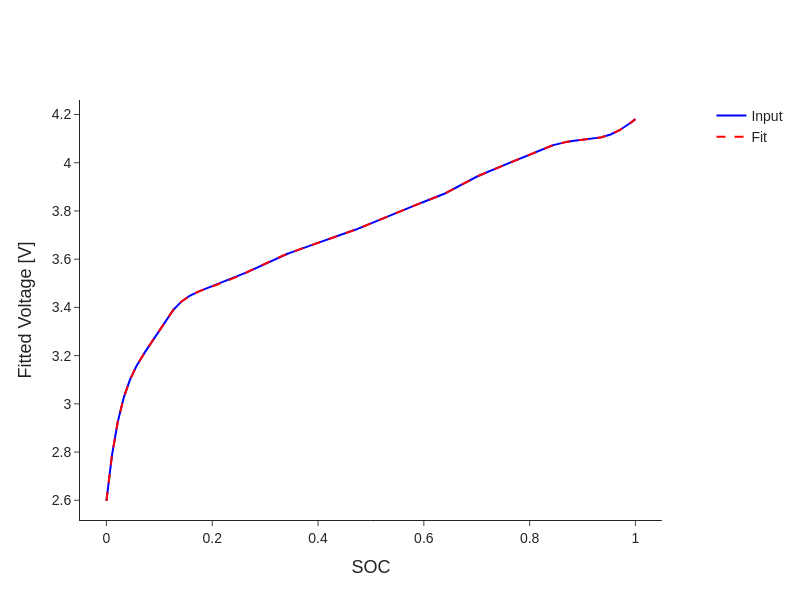

In [6]:
fig = pyprobe.Plot()
fig.add_line(fitted_curve, x='SOC', y='Input Voltage [V]',label = "Input")
fig.add_line(fitted_curve, x='SOC', y='Fitted Voltage [V]', color='red', label = 'Fit', dash='dash')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

You can also fit to differentiated voltage data:

shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ x_pe low   ┆ x_pe high  ┆ x_ne low   ┆ x_ne high ┆ Cell      ┆ Cathode   ┆ Anode     ┆ Li        │
│ SOC        ┆ SOC        ┆ SOC        ┆ SOC       ┆ Capacity  ┆ Capacity  ┆ Capacity  ┆ Inventory │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      ┆ [Ah]      │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.849925   ┆ 0.27001    ┆ 0.030003   ┆ 0.900015  ┆ 5.0       ┆ 8.621949  ┆ 5.747048  ┆ 7.500442  │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


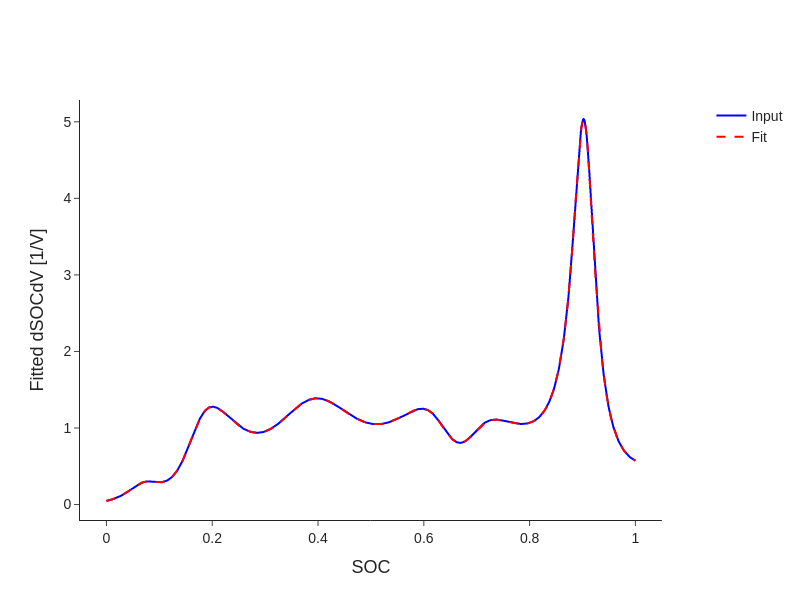

In [7]:
stoichiometry_limits, fitted_curve = dma_object.fit_ocv(x_ne = z,
                   x_pe = z,
                   ocp_ne = ocp_ne,
                   ocp_pe = ocp_pe,
                   x_guess = [0.9, 0.1, 0.1, 0.9],
                   fitting_target = 'dQdV')
print(stoichiometry_limits.data)
fig = pyprobe.Plot()
fig.add_line(fitted_curve, x='SOC', y='Input dSOCdV [1/V]',label = "Input")
fig.add_line(fitted_curve, x='SOC', y='Fitted dSOCdV [1/V]', color='red', label = 'Fit', dash='dash')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation